In [1]:
import torch
import numpy as np
import sys
import os

sys.path.append(os.getcwd()+'/src/')
%load_ext autoreload
%autoreload 2

from attribute import *
from plot import *
from ppo_policy import *

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from stable_baselines3 import DQN

In [20]:
model = DQN.load('../best_model/dqn/MlpPolicy/best_model.zip')
# model = DQN.load('../output_models/dqn/MlpPolicy/2022-06-06_21_48_53_32.zip')
dqn_net = model.q_net
model.load_replay_buffer("../best_model/dqn/MlpPolicy/best_model_rb")
X = model.replay_buffer.observations
X = torch.Tensor(X)

In [17]:
X = np.load('../best_model/dqn/MlpPolicy/observations.npy')
X = torch.Tensor(X)
X.shape

torch.Size([1836, 1, 7])

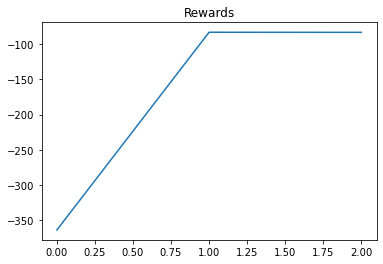

In [18]:
plot_rewards("../best_model/dqn/MlpPolicy/best_model_rewards.csv")

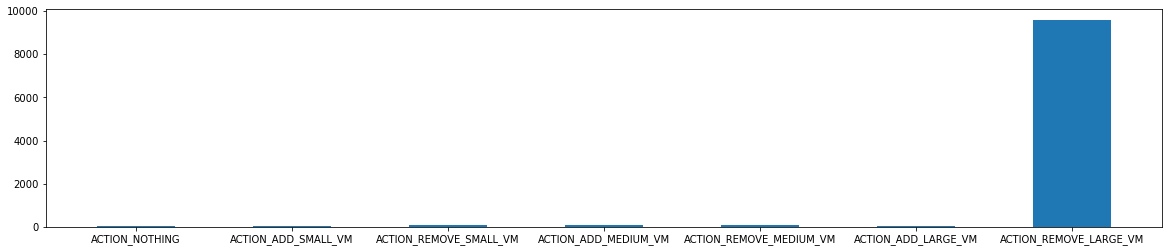

In [21]:
plot_action_histogram(model, X)

In [7]:
ig_attributor = IGAttributor(net=dqn_net,
                             agent='dqn',
                             policy='mlp',
                             data=X[:100])
mean_attributions = ig_attributor.get_mean_attributions()


torch.Size([100, 1, 7])


In [15]:
mean_attributions[0].shape

(1, 7)

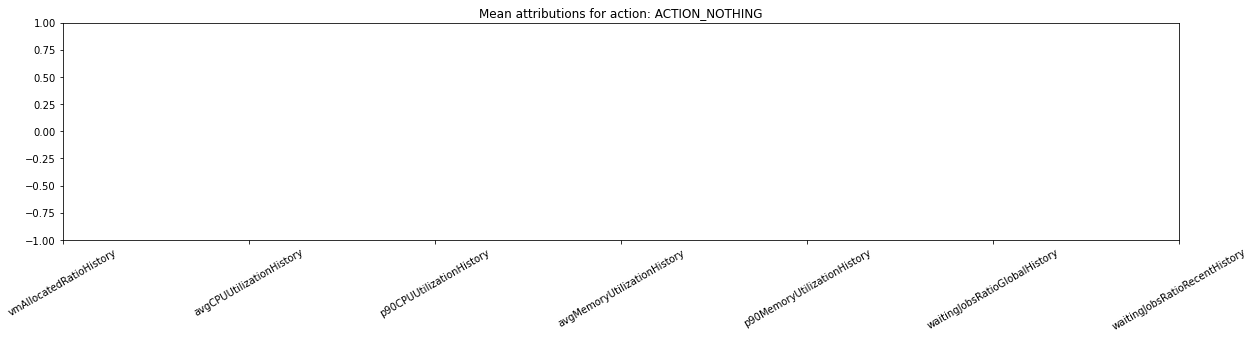

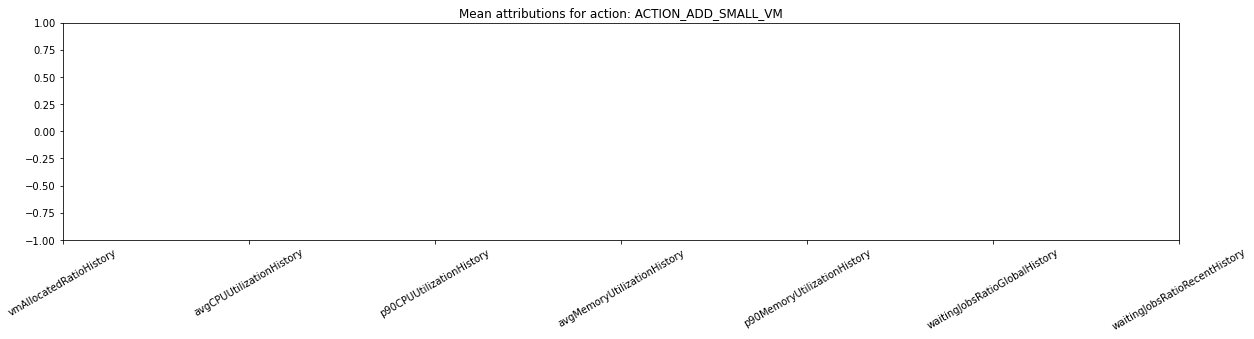

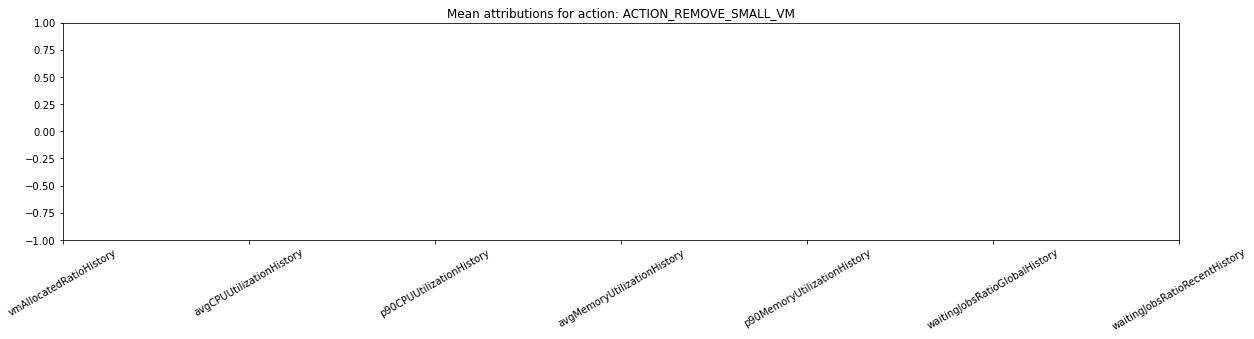

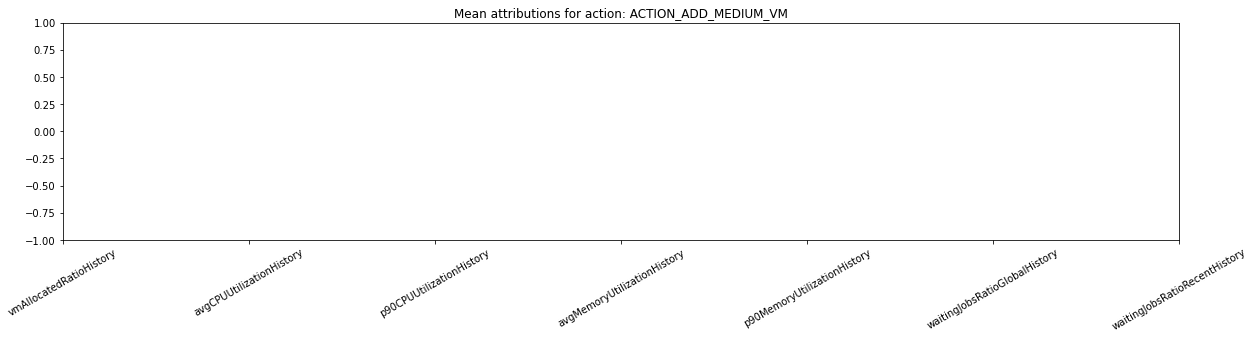

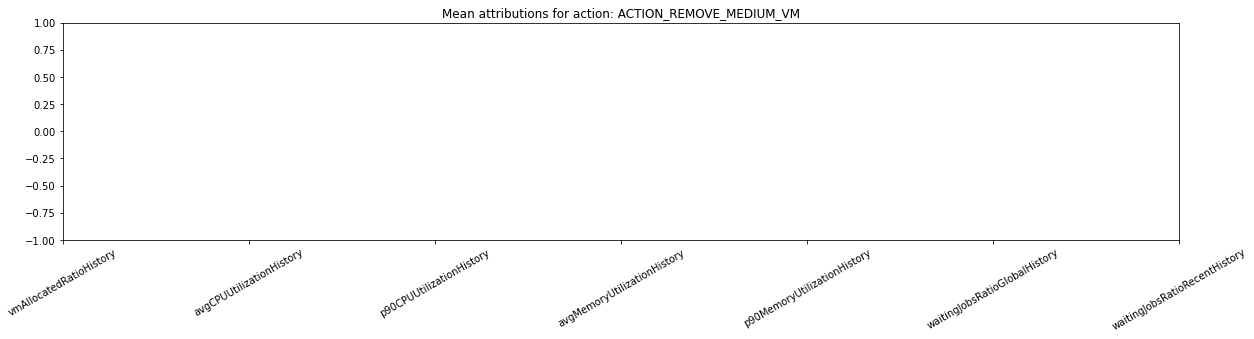

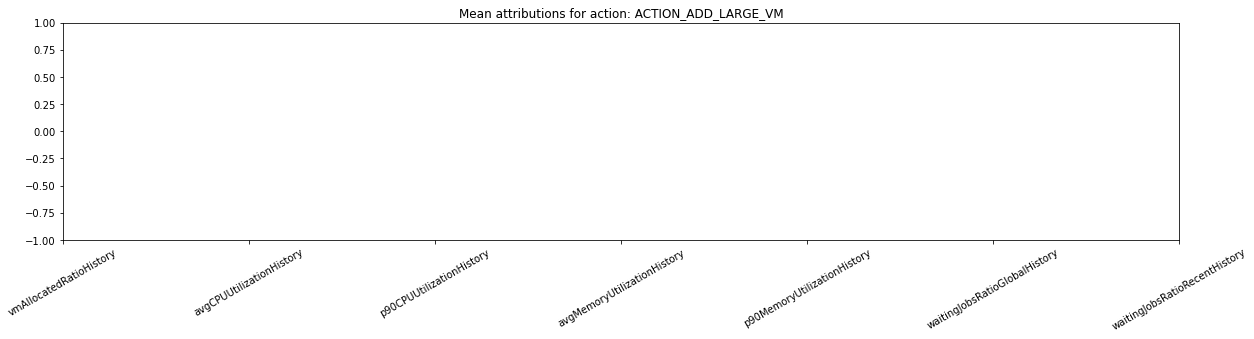

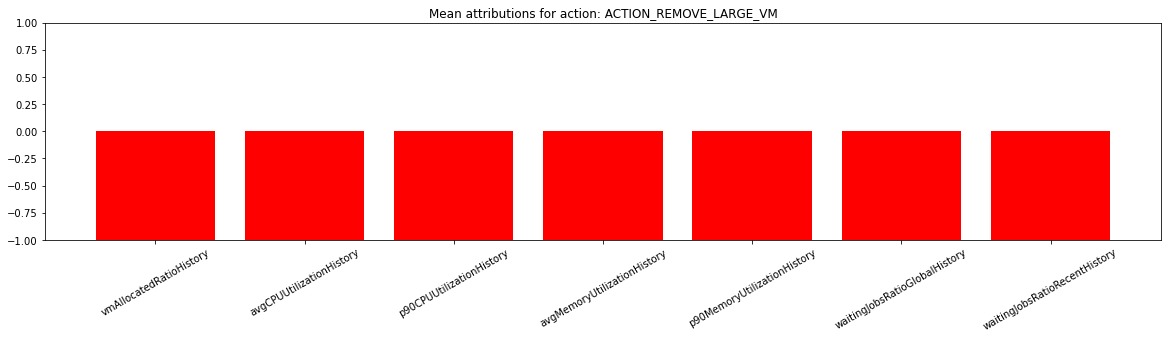

In [8]:
plot_mean_attributions(mean_attributions=mean_attributions)

Action made: ACTION_NOTHING
Q-values:
ACTION_NOTHING: -72.27326965332031
ACTION_ADD_SMALL_VM: -72.33419799804688
ACTION_REMOVE_SMALL_VM: -72.51994323730469
ACTION_ADD_MEDIUM_VM: -72.3113021850586
ACTION_REMOVE_MEDIUM_VM: -72.66653442382812
ACTION_ADD_LARGE_VM: -73.81426239013672
ACTION_REMOVE_LARGE_VM: -74.0522232055664


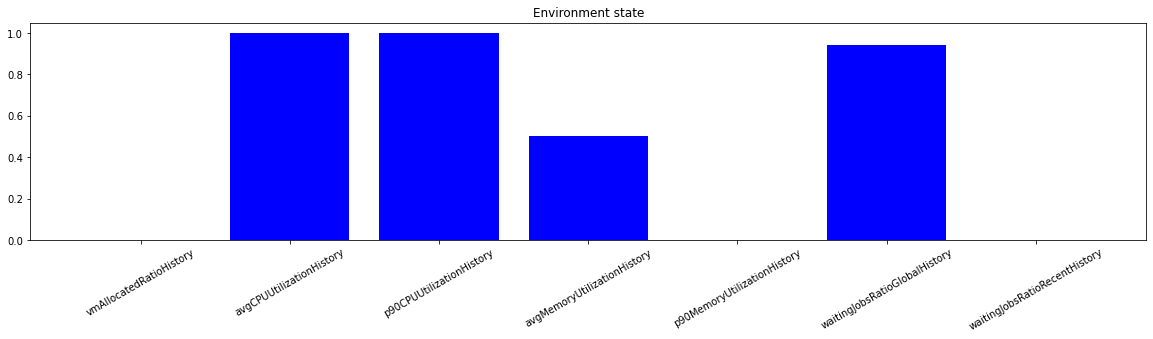

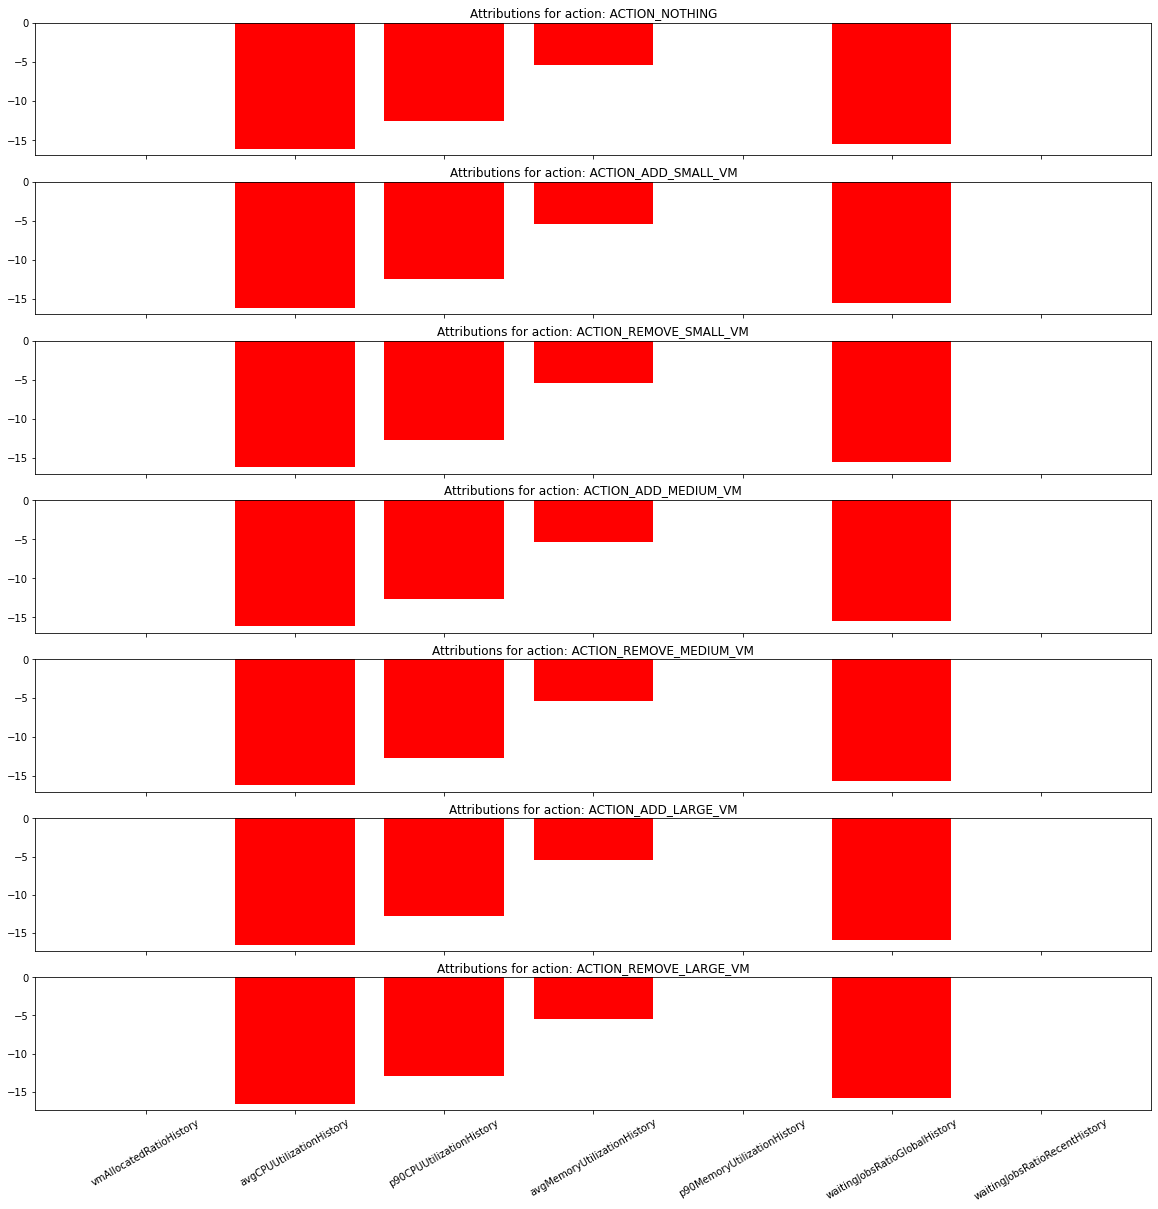

In [9]:
ig_attributor.explain_example(idx=2)

In [10]:
X_manual = torch.Tensor([
    [[0, 1, 1, 1, 1, 1, 1]],
    [[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]],
    [[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]
    ])

In [11]:
X_manual.shape

torch.Size([3, 1, 7])

In [12]:
ig_attributor = IGAttributor(net=dqn_net,
                             agent='dqn',
                             policy='mlp',
                             data=X_manual)

torch.Size([3, 1, 7])


Action made: ACTION_ADD_MEDIUM_VM
Q-values:
ACTION_NOTHING: -67.46576690673828
ACTION_ADD_SMALL_VM: -67.49060821533203
ACTION_REMOVE_SMALL_VM: -67.55006408691406
ACTION_ADD_MEDIUM_VM: -67.46214294433594
ACTION_REMOVE_MEDIUM_VM: -67.69151306152344
ACTION_ADD_LARGE_VM: -68.8528823852539
ACTION_REMOVE_LARGE_VM: -69.0411605834961


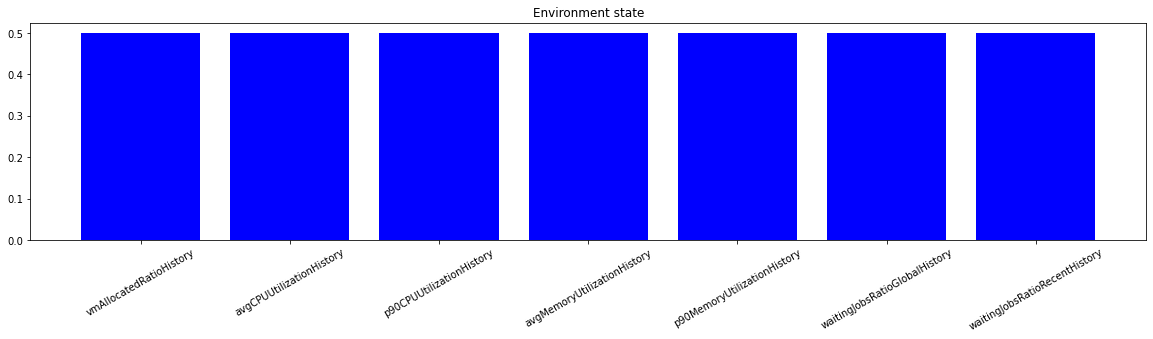

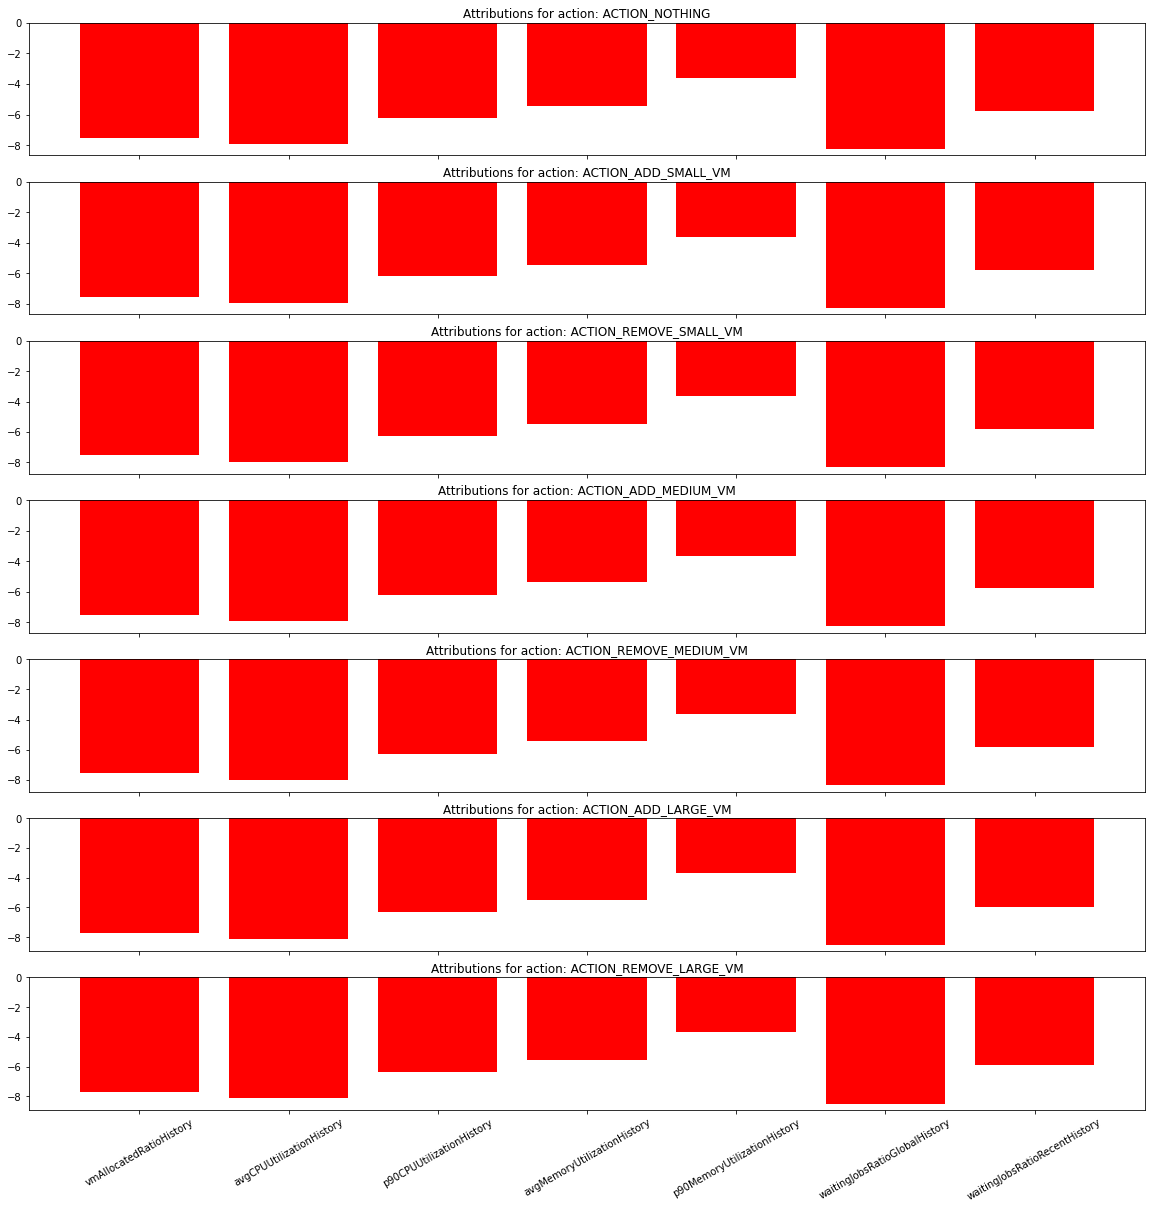

In [13]:
ig_attributor.explain_example(idx=1)